# inference_dev
notebook for developing inference pipeline with wtf setup

In [1]:
import numpy as np
import tinygp
from tinygp import GaussianProcess
from tinygp import kernels
import json
import pickle
import pandas as pd

from scripts import pitchfork_compile, pitchfork_sampler, inspect_star

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

In [2]:
with open('pitchfork/pitchfork.json', 'r') as fp:
    pitchfork_dict = json.load(fp)

with open('pitchfork/pitchfork_info.json', 'r') as fp:
    pitchfork_info = json.load(fp)

pitchfork_cov = np.loadtxt('pitchfork/pitchfork_covariance.txt')

pitchfork = pitchfork_compile(pitchfork_dict, pitchfork_info)

## define priors

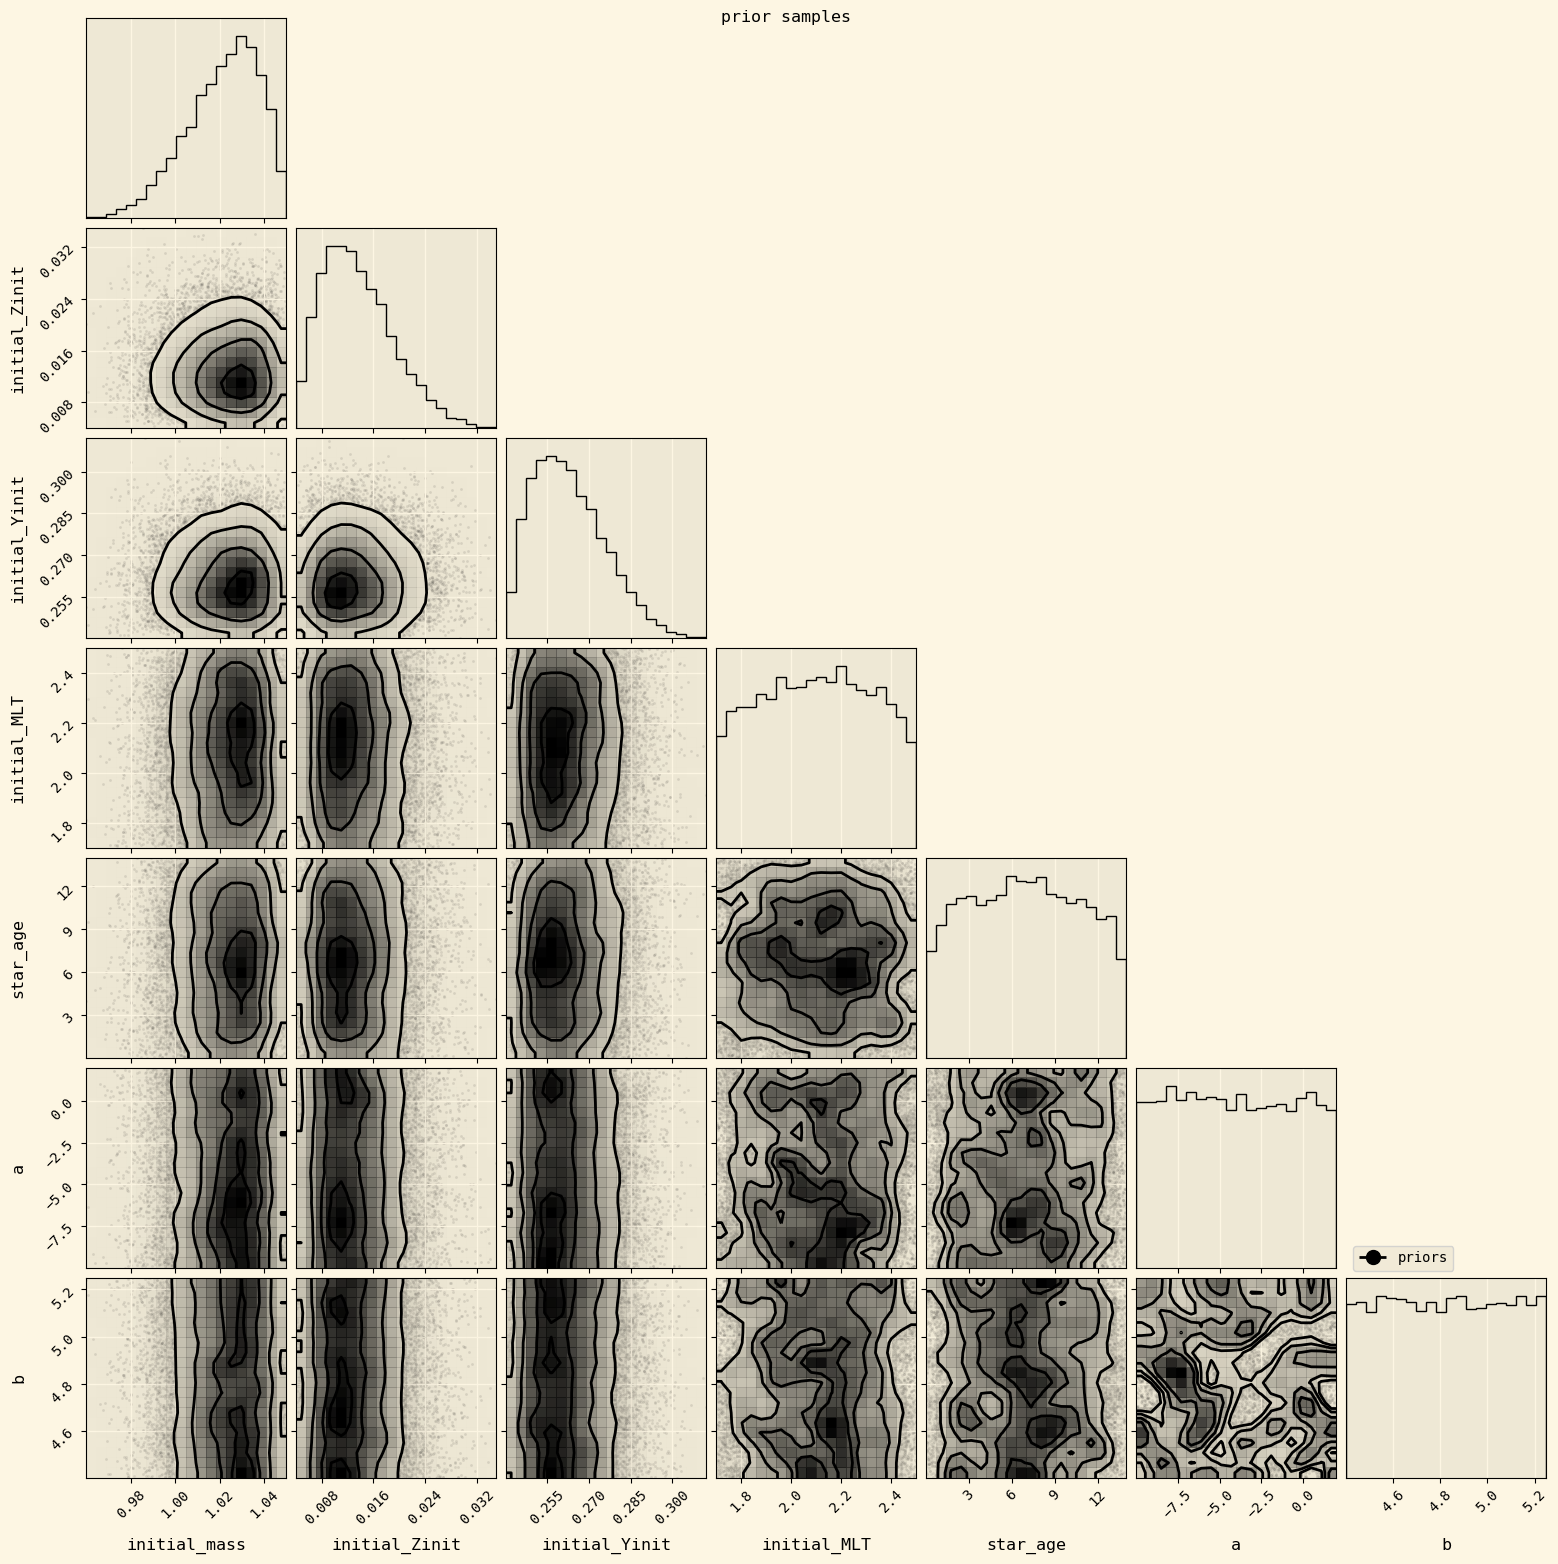

In [3]:
from scripts import beta_prior, uniform_prior

labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = beta_prior(0.95, 1.05, a=5, b=2)

Zinit_prior = beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = uniform_prior(-10, 2)

b_prior = uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

## define likelihood covariance matrix

In [4]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov, priors=priors)

In [5]:
%%time
results = sampler('Sun', save=True)

[ultranest] Sampling 400 live points from prior ...


Z=-19.0(14.17%) | Like=-6.56..-2.48 [-6.9120..-6.4659] | it/evals=4916/94827 eff=5.2061% N=400        0  0  0 0 

/home/oxs235/miniconda3/envs/pitchfork/lib/python3.13/site-packages/ultranest/integrator.py:1903: UserWarning: Sampling from region seems inefficient (0/32768 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


[ultranest] Explored until L=-2  74 [-2.3073..-2.3071]*| it/evals=7782/155981 eff=4.8005% N=400  
[ultranest] Likelihood function evaluations: 155981
[ultranest]   logZ = -17.01 +- 0.1316
[ultranest] Effective samples strategy satisfied (ESS = 2509.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
CPU times: user 5min 41s, sys: 932 ms, total: 5min 42s
Wall time: 3min 27s


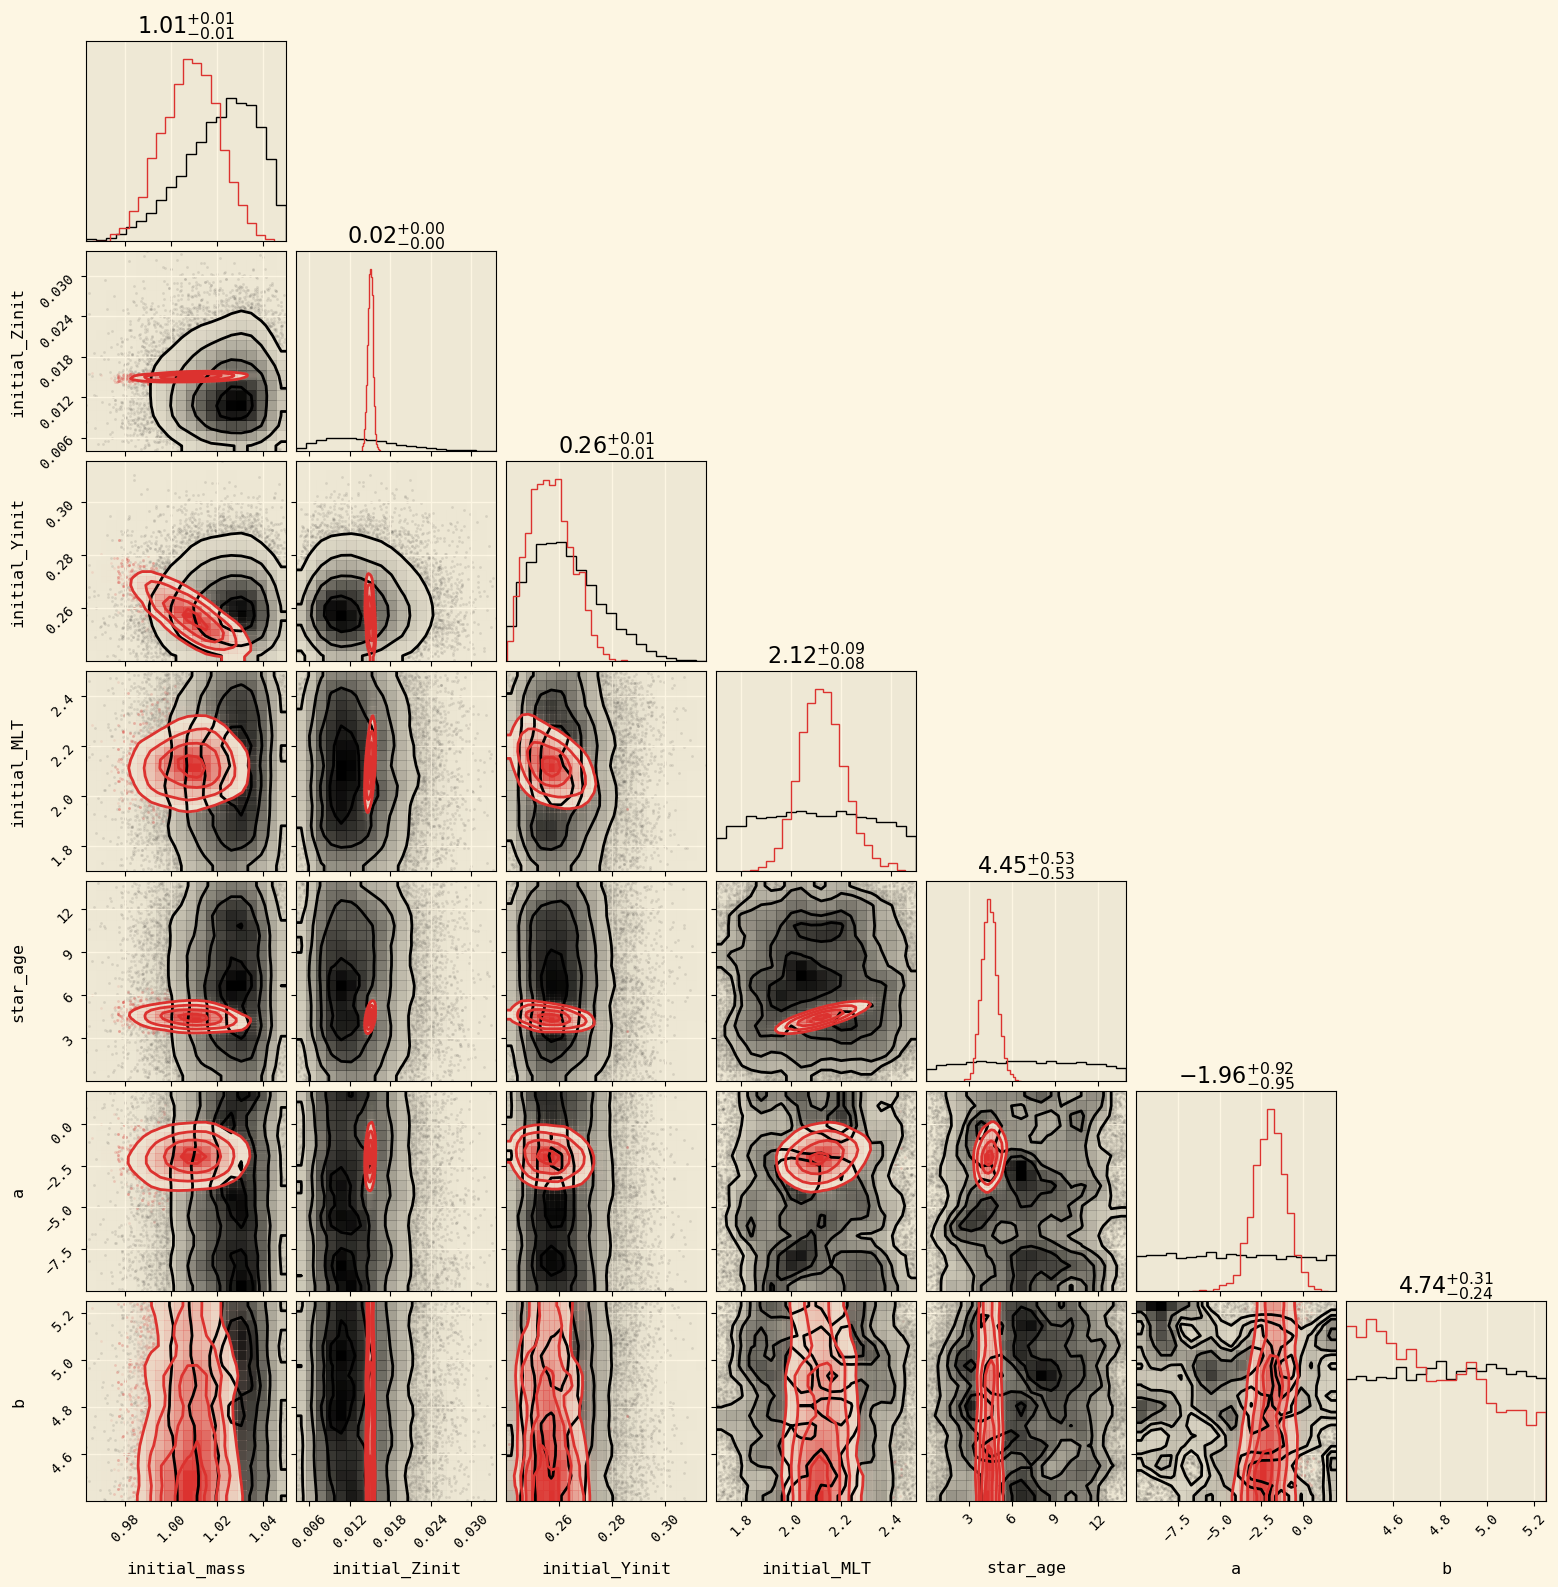

In [6]:
def inspect_star(star_name, color = '#DC322F', n_prior_samples = 10000):
    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    with open(f'stars/{star_name}/{star_name}_results.pkl', 'rb') as fp:
        results = pickle.load(fp)
    
    priors = results['priors']

    prior_samples = np.array([prior.rvs(size=n_prior_samples) for prior in priors])
    
    figure = corner.corner(prior_samples.T, labels = labels, color='black', hist_kwargs={'density':True}, smooth=True);

    corner.corner(results['samples'], fig=figure, color=color, hist_kwargs={'density':True}, smooth=True,show_titles=True);
    
inspect_star('Sun')

In [7]:
%%time
results = sampler('16CygA', save=True)

[ultranest] Sampling 400 live points from prior ...


/home/oxs235/repos/ojscutt/pitchfork/scripts/compile_from_dict.py:106: RuntimeWarning: overflow encountered in exp
  return self.np.where(x >= 0, x, self.np.exp(x)-1)


/home/oxs235/repos/ojscutt/pitchfork/scripts/compile_from_dict.py:106: RuntimeWarning: overflow encountered in exp
  return self.np.where(x >= 0, x, self.np.exp(x)-1)


Z=-25.0(24.98%) | Like=-13.31..-10.61 [-13.3143..-13.3128]*| it/evals=4653/314751 eff=1.4802% N=400    0  0 0 0  

/home/oxs235/miniconda3/envs/pitchfork/lib/python3.13/site-packages/ultranest/integrator.py:1903: UserWarning: Sampling from region seems inefficient (0/32768 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  u, v, logl, nc, quality = self._refill_samples(Lmin, ndraw, nit)


[ultranest] Explored until L=-1e+01   [-10.7349..-10.7344]*| it/evals=7012/619452 eff=0.6234% N=400 
[ultranest] Likelihood function evaluations: 620436
[ultranest]   logZ = -23.55 +- 0.1291
[ultranest] Effective samples strategy satisfied (ESS = 2093.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
CPU times: user 19min 17s, sys: 885 ms, total: 19min 18s
Wall time: 4min 43s


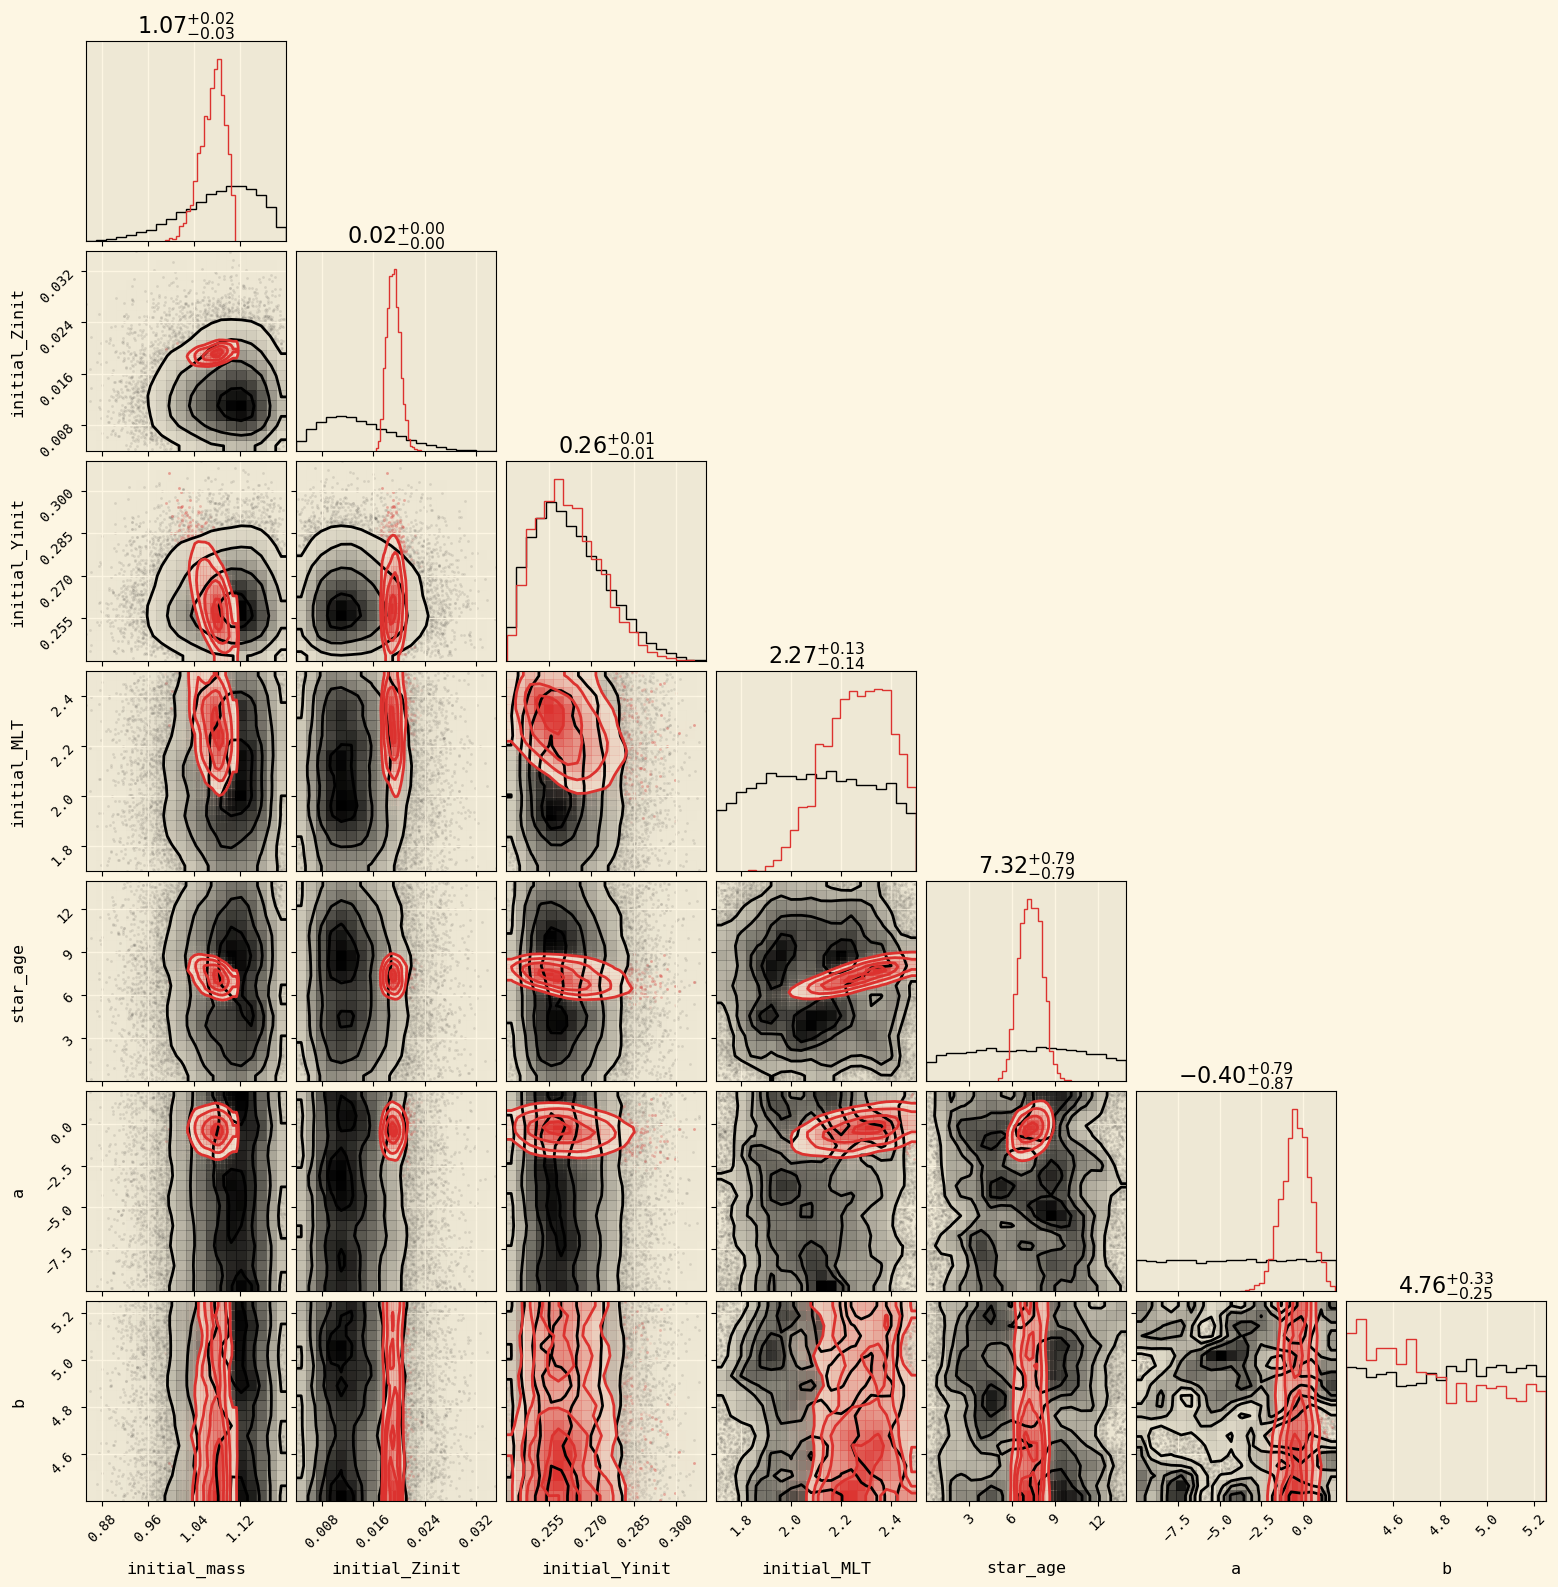

In [8]:
inspect_star('16CygA')